# Predictia numerelor castigatoare la lotto

In [47]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

1. Reading the data from our database


In [48]:
df_extr = pd.read_excel('extrageri.xlsx', sheet_name ='EXTRAGERI')
df_extr.head()

,DATA,N1,N2,N3,N4,N5,N6
0,"Sb, 31 decembrie 2022",13,4,35,19,10,7
1,"Sb, 24 decembrie 2022",39,41,28,1,45,4
2,"Du, 18 decembrie 2022",3,21,40,26,16,15
3,"Jo, 15 decembrie 2022",33,39,46,4,26,8
4,"Du, 11 decembrie 2022",45,8,12,41,35,30


Verificarea tipurilor de date.

In [49]:
df_extr.dtypes

DATA    object
N1       int64
N2       int64
N3       int64
N4       int64
N5       int64
N6       int64
dtype: object

Functii pentru prelucrarea datei

In [50]:
luni = {
    'ianuarie' :1,
    'februarie' :2,
    'martie':3,
    'aprilie':4,
    'mai':5,
    'iunie':6,
    'iulie':7,
    'august':8,
    'septembrie':9,
    'octombrie':10,
    'noiembrie':11,
    'decembrie':12
}

# Function to remove day abbreviation from a date
def remove_day_abbreviation(date):
    day, rest_of_date = date.split(",", 1)
    return rest_of_date.split('\n')[0].strip()

# Function to extract and convert the month to its corresponding number
def extract_and_convert_month(date):
    parts = date.split()
    month_name = parts[1]  
    month_number = luni.get(month_name.lower(), None)
    parts[1] = str(month_number)
    modified_date = '.'.join(parts)
    return modified_date


def process_dates(dataframe):
    dates = []
    for date in dataframe['DATA']:
        dates.append(remove_day_abbreviation(date))

    for i in range(0,len(dates)):
        dates[i] = extract_and_convert_month(dates[i])
    return dates



In [51]:
df_extr['DATA'] = process_dates(df_extr)
df_extr['DATA'] = pd.to_datetime(df_extr['DATA'], format ='%d.%m.%Y')
df_extr.head()

,DATA,N1,N2,N3,N4,N5,N6
0,2022-12-31,13,4,35,19,10,7
1,2022-12-24,39,41,28,1,45,4
2,2022-12-18,3,21,40,26,16,15
3,2022-12-15,33,39,46,4,26,8
4,2022-12-11,45,8,12,41,35,30


Studying the numbers extracted

In [52]:
n1_values = df_extr['N1'].tolist()

n2_values = df_extr['N2'].tolist()

n3_values = df_extr['N3'].tolist()

n4_values = df_extr['N4'].tolist()

n5_values = df_extr['N5'].tolist()

n6_values = df_extr['N6'].tolist()

# Combine all ball values into a single list
all_values = (
    n1_values +
    n2_values +
    n3_values +
    n4_values +
    n5_values +
    n6_values
)


my_list = np.zeros(49)

for no in all_values:
    for i in range(1,50):
        # print(i)
        if(no == i):
            my_list[i-1] = my_list[i-1] + 1

print(my_list)

# Checking result
msum = 0
for no in my_list:
    msum = msum + no
print(msum)
print(len(all_values))


[107. 131. 115. 139. 133. 129. 113. 123. 108. 129. 118. 116. 112. 100.
 104. 118. 116. 114. 106.  97. 117. 101. 120. 116. 142. 102. 128. 119.
  92. 114.  90. 123. 104. 110.  98. 120. 112. 115. 111. 110. 103. 101.
 112. 115. 109. 114. 101. 115. 108.]
5550.0
5550


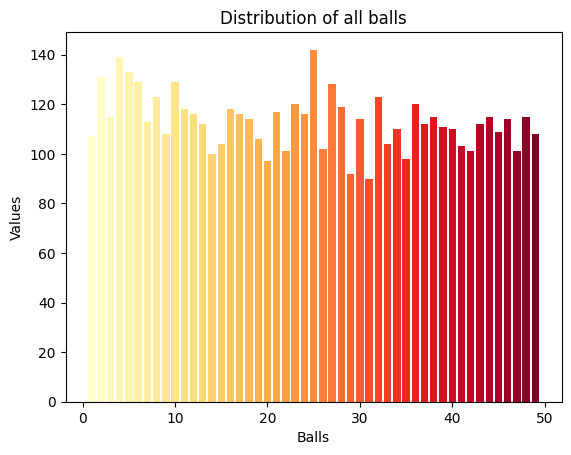

In [53]:
balls = list(range(1, 50, 1))
all_balls = pd.Series(balls)

values = all_balls.values

colors = plt.cm.YlOrRd(np.linspace(0, 1, len(values)))

plt.bar(balls, my_list, color=colors)

plt.xlabel('Balls')
plt.ylabel('Values')
plt.title('Distribution of all balls')


plt.show()


Most common numbers

In [54]:
ball_counts = pd.Series(all_values).value_counts().sort_index()

most_frequent_numbers = ball_counts.head(6).index.tolist()
print("The 6 most frequent numbers:", most_frequent_numbers)

The 6 most frequent numbers: [1, 2, 3, 4, 5, 6]


    Ball
13    14
45    46
47    48
44    45
17    18
27    28
26    27
25    26
31    32
19    20


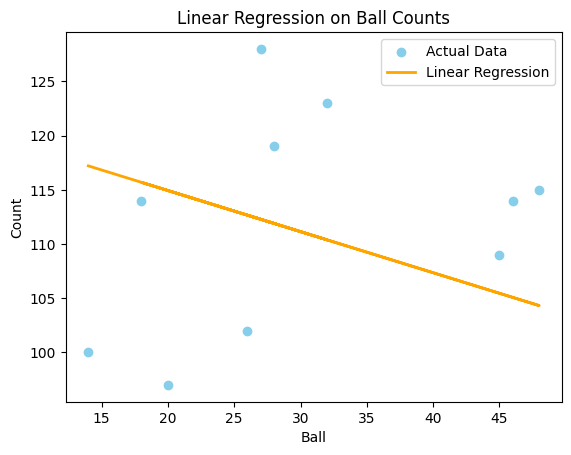

In [55]:
ball_counts_df = pd.DataFrame({'Ball': ball_counts.index, 'Count': ball_counts.values})

X = ball_counts_df[['Ball']]
y = ball_counts_df['Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(X_test)

plt.scatter(X_test, y_test, color='skyblue', label='Actual Data')
plt.plot(X_test, y_pred, color='orange', linewidth=2, label='Linear Regression')
plt.xlabel('Ball')
plt.ylabel('Count')
plt.title('Linear Regression on Ball Counts')
plt.legend()
plt.show()

In [56]:
from collections import Counter

ball_counts = Counter(all_values)

most_frequent_numbers = [num for num, count in ball_counts.most_common(6)]
print("The 6 most frequent numbers:", most_frequent_numbers)



The 6 most frequent numbers: [25, 4, 5, 2, 6, 10]


Din seturile de numere voiam sa extrag si sa etichez cu 1- castigator ce date aveam de la arhiva loteriei si sa creez eu siruri necastigatoare, urmand sa folosesc RandomForestClassifier din libraria sklearn pentru a face o predictie. Acest lucru mi-a depasit capacitatile caci selectarea a 10 siruri castigatoare combina atat de multe numere incat functia mea nu gasea destule siruri pe care sa le etichetez necastigatoare. Esecul de a construii un set de date echilibrat pentru a putea face o predictie cat de cat aproape de a fi relevanta m-a facut sa renunt la partea aceasta atasand proiectului doar niste statistici asupra setului de numere extrase.

## Predictia numarului de castigatori
Verificarea datelor din dataframes si verificarea tipurilor de date

In [57]:
df_cat1 = pd.read_excel('extrageri.xlsx', sheet_name ='CATEGORIA I')
df_cat1.head()

,DATA,NumarCastiguri,ValoareCastig,Report
0,"Sb, 31 decembrie 2022",REPORT,"0,00","0,00"
1,"Sb, 24 decembrie 2022",REPORT,"1.221.675,36","0,00"
2,"Du, 18 decembrie 2022",REPORT,"645.814,32","0,00"
3,"Jo, 15 decembrie 2022",REPORT,"366.792,00","0,00"
4,"Du, 11 decembrie 2022",REPORT,"631.063,92","0,00"


In [58]:
df_cat2 = pd.read_excel('extrageri.xlsx', sheet_name ='CATEGORIA II')
df_cat2.head()

,DATA,NumarCastiguri,ValoareCastig,Report
0,"Sb, 31 decembrie 2022",38,"10.554,11","0,00"
1,"Sb, 24 decembrie 2022",5,"81.445,02","0,00"
2,"Du, 18 decembrie 2022",8,"26.908,93","0,00"
3,"Jo, 15 decembrie 2022",10,"12.226,40","0,00"
4,"Du, 11 decembrie 2022",4,"52.588,66","0,00"


In [59]:
df_cat3 = pd.read_excel('extrageri.xlsx', sheet_name ='CATEGORIA III')
df_cat3.head()

,DATA,NumarCastiguri,ValoareCastig,Report
0,"Sb, 31 decembrie 2022",2.043,"196,30","0,00"
1,"Sb, 24 decembrie 2022",348.000,"1.170,18","0,00"
2,"Du, 18 decembrie 2022",362.000,"594,67","0,00"
3,"Jo, 15 decembrie 2022",375.000,"326,03","0,00"
4,"Du, 11 decembrie 2022",298.000,"705,88","0,00"


In [60]:

df_cat4 = pd.read_excel('extrageri.xlsx', sheet_name ='reduced_data')
df_cat4.head()


,DATA,NumarCastiguri,ValoareCastig,Report
0,"Du, 31 decembrie 2017",14.761,"30,00","0,00"
1,"Du, 24 decembrie 2017",13.126,"30,00","0,00"
2,"Jo, 21 decembrie 2017",4.571,"30,00","0,00"
3,"Du, 17 decembrie 2017",5.116,"30,00","0,00"
4,"Jo, 14 decembrie 2017",4.401,"30,00","0,00"


In [61]:
df_test = pd.read_excel('extrageri.xlsx', sheet_name ='CATEGORIA IV')
df_test.head()

,DATA,NumarCastiguri,ValoareCastig,Report
0,"Sb, 31 decembrie 2022",29.779,"30,00","0,00"
1,"Sb, 24 decembrie 2022",8.602,"30,00","0,00"
2,"Du, 18 decembrie 2022",7.743,"30,00","0,00"
3,"Jo, 15 decembrie 2022",4.811,"30,00","0,00"
4,"Du, 11 decembrie 2022",6.322,"30,00","0,00"


In [62]:
df_cat1.dtypes

DATA              object
NumarCastiguri    object
ValoareCastig     object
Report            object
dtype: object

In [63]:
df_cat2.dtypes

DATA              object
NumarCastiguri    object
ValoareCastig     object
Report            object
dtype: object

In [64]:
df_cat3.dtypes

DATA               object
NumarCastiguri    float64
ValoareCastig      object
Report             object
dtype: object

In [65]:
df_cat4.dtypes

DATA               object
NumarCastiguri    float64
ValoareCastig      object
Report             object
dtype: object

### Procesare de date
Transformarea datelor in string pentru a putea lucra cu ele
Transformarea datei('DATA') in datetime si popularea dataframe-ului cu noile valori

In [66]:
df_extr['DATA'] = df_extr['DATA'].astype(str)

df_cat4['DATA'] = df_cat4['DATA'].astype(str)


In [67]:
df_cat4['DATA'] = process_dates(df_cat4)
df_cat4['DATA'] = pd.to_datetime(df_cat4['DATA'], format ='%d.%m.%Y')
df_cat4.head()


df_test['DATA'] = process_dates(df_test)
df_test['DATA'] = pd.to_datetime(df_test['DATA'], format ='%d.%m.%Y')
df_test.head()


,DATA,NumarCastiguri,ValoareCastig,Report
0,2022-12-31,29.779,"30,00","0,00"
1,2022-12-24,8.602,"30,00","0,00"
2,2022-12-18,7.743,"30,00","0,00"
3,2022-12-15,4.811,"30,00","0,00"
4,2022-12-11,6.322,"30,00","0,00"


Check datatypes

In [68]:
df_extr.dtypes

DATA    object
N1       int64
N2       int64
N3       int64
N4       int64
N5       int64
N6       int64
dtype: object

In [69]:
df_cat4.dtypes

DATA              datetime64[ns]
NumarCastiguri           float64
ValoareCastig             object
Report                    object
dtype: object

In [70]:
df_cat2['NumarCastiguri'] = df_cat2['NumarCastiguri'].replace('REPORT', '0')
df_cat1['NumarCastiguri'] = df_cat1['NumarCastiguri'].replace('REPORT', '0')
df_cat4['NumarCastiguri'] = df_cat4['NumarCastiguri'].astype(str).str.replace('.', '').astype(int)
df_test['NumarCastiguri'] = df_cat4['NumarCastiguri'].astype(str).str.replace('.', '').astype(int)

In [71]:
df_cat1['NumarCastiguri'] = pd.to_numeric(df_cat1['NumarCastiguri'], errors='coerce')
df_cat2['NumarCastiguri'] = pd.to_numeric(df_cat2['NumarCastiguri'], errors='coerce')
df_cat3['NumarCastiguri'] = pd.to_numeric(df_cat3['NumarCastiguri'], errors='coerce')
df_cat4['NumarCastiguri'] = pd.to_numeric(df_cat4['NumarCastiguri'], errors='coerce')
df_test['NumarCastiguri'] = pd.to_numeric(df_test['NumarCastiguri'], errors='coerce')

In [72]:
#Verificarea lungimii coloanelor pentru a nu intampina probleme
print(len(df_cat4['DATA']))
print(len(df_cat4['NumarCastiguri']))

611
611


#### Evaluarea numarului de castigatori pe axa timpului

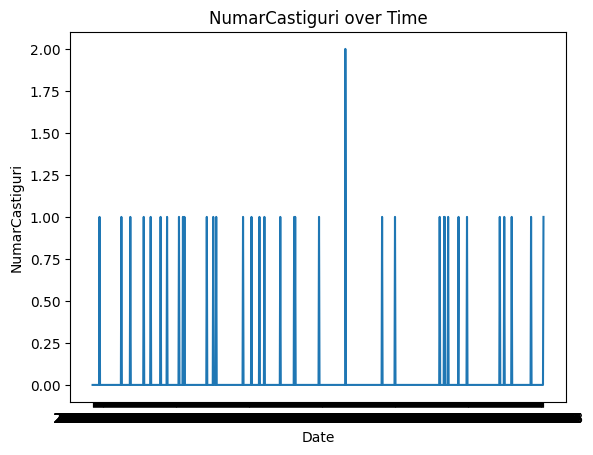

In [73]:
plt.plot(df_extr['DATA'], df_cat1['NumarCastiguri'])
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.show()


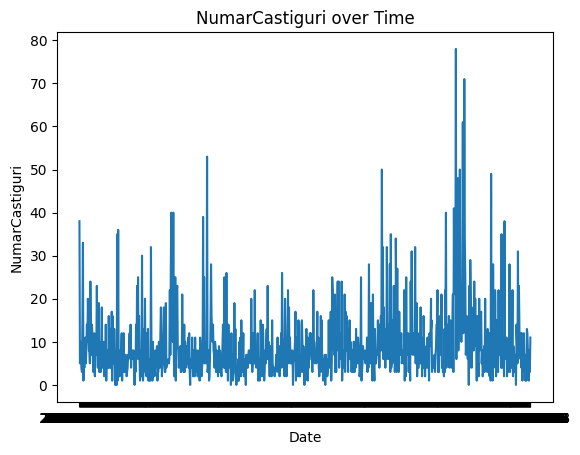

In [74]:
plt.plot(df_extr['DATA'],df_cat2['NumarCastiguri'])
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.show()

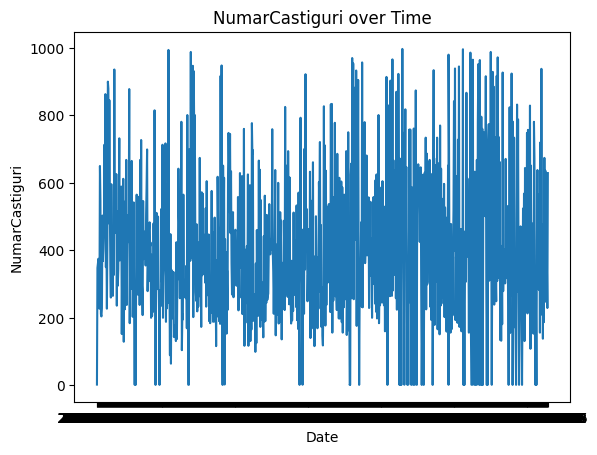

In [75]:
plt.plot(df_extr['DATA'],df_cat3['NumarCastiguri'])
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.show()

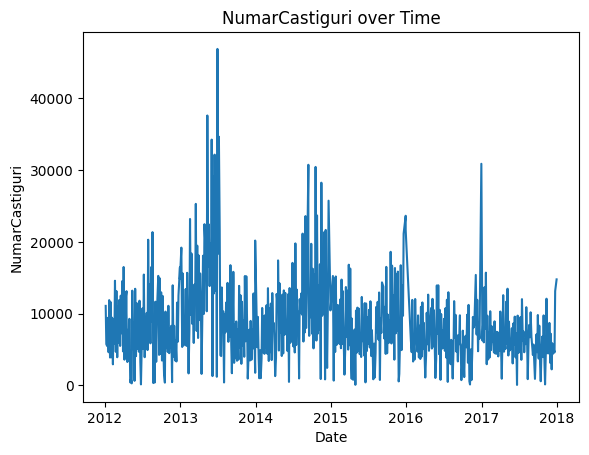

In [76]:
plt.plot(df_cat4['DATA'],df_cat4['NumarCastiguri'])
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.show()

Dupa analizarea datelor, am luat decizia de a alege categoria IV pentru ca este cea mai consistenta

Precizare:  Acesta reprezentare a df_cat4 este dupa impartirea datelor in antrenare si validare 
            Acest interval de timp a fost ales pentru ca nu are date lipsa.
            Restul garficelor reprezentate au toate datele pe axa de timp

Interpolarea datelor din categoria 4
(sau o incercare)

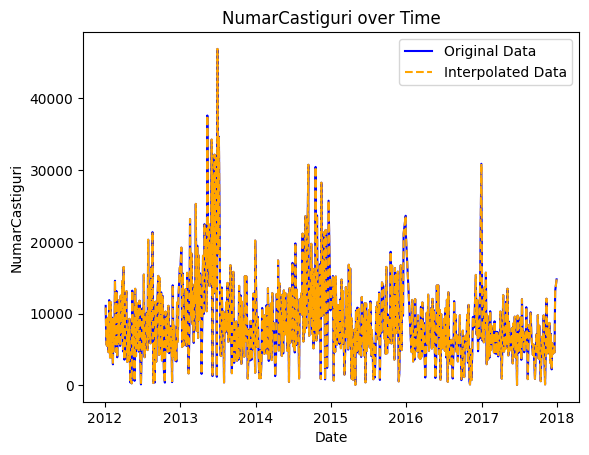

In [77]:
plt.plot(df_cat4['DATA'], df_cat4['NumarCastiguri'], label='Original Data', color='blue')

# Interpolare
df_cat4['NumarCastiguri_interpolated'] = df_cat4['NumarCastiguri'].interpolate(method='linear')

plt.plot(df_cat4['DATA'], df_cat4['NumarCastiguri_interpolated'], label='Interpolated Data',linestyle='dashed', color='orange')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.legend()
plt.show()

Netezire cu Transformata Fourier

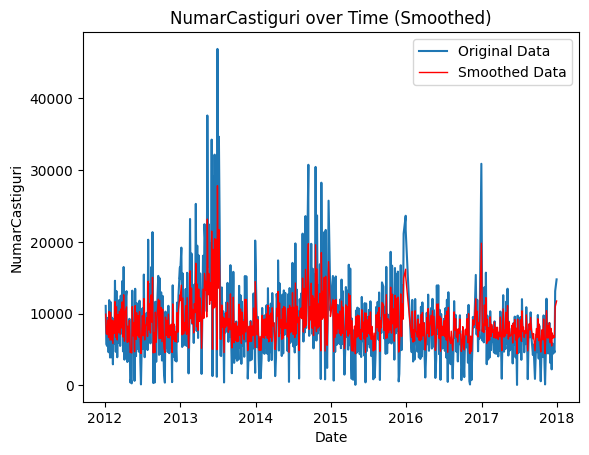

In [78]:
x = np.array(df_cat4['DATA'])
y = np.array(df_cat4['NumarCastiguri'])

# Aplicam transformata Fourier
fft_result = np.fft.fft(y)
# Frecvența semnalului
frequencies = np.fft.fftfreq(len(fft_result))

cutoff_frequency = 0.001 
fft_result[frequencies > cutoff_frequency] = 0
smoothed_data = np.fft.ifft(fft_result).real

plt.plot(x, y, label='Original Data')

plt.plot(x, smoothed_data, label='Smoothed Data', linewidth=1, color='red')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time (Smoothed)')
plt.legend()
plt.show()


Netezirea cu media alunecatoare

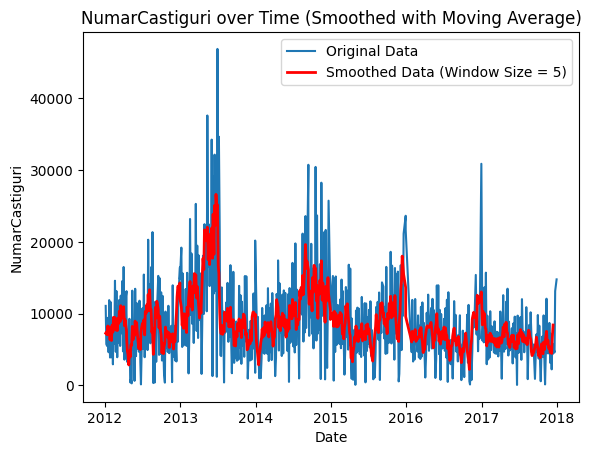

In [79]:
x = df_cat4['DATA']
y = df_cat4['NumarCastiguri']

window_size = 5

smoothed_data = 0
smoothed_data = y.rolling(window=window_size).mean()

plt.plot(x, y, label='Original Data')

plt.plot(x, smoothed_data, label=f'Smoothed Data (Window Size = {window_size})', linewidth=2, color='red')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time (Smoothed with Moving Average)')
plt.legend()
plt.show()


In [80]:
df_cat4['NumarCastiguri_netezite'] = smoothed_data
for i in range(0,10):
    print(df_cat4['NumarCastiguri_netezite'][i])

nan
nan
nan
nan
8395.0
6612.0
4428.2
4947.0
4547.6
5404.8


Observam ca netezirea a adaugat niste NaN de care trebuie sa scapam.

In [81]:
df_cat4['NumarCastiguri_netezite'] = smoothed_data

df_cat4 = df_cat4.iloc[4:]

df_cat4.reset_index(drop=True, inplace=True)

df_cat4[['DATA', 'NumarCastiguri_netezite']].head()

,DATA,NumarCastiguri_netezite
0,2017-12-14,8395.0
1,2017-12-10,6612.0
2,2017-12-07,4428.2
3,2017-12-03,4947.0
4,2017-11-30,4547.6


Aplicarea algoritmului de regresie liniara pe numarul castigatorilor.

In [82]:
df_cat4.dtypes

DATA                           datetime64[ns]
NumarCastiguri                          int32
ValoareCastig                          object
Report                                 object
NumarCastiguri_interpolated             int32
NumarCastiguri_netezite               float64
dtype: object

In [83]:
df_cat4['NumarCastiguri_netezite'].astype(int)

0      8395
1      6612
2      4428
3      4947
4      4547
       ... 
602    7160
603    8262
604    7036
605    7409
606    7248
Name: NumarCastiguri_netezite, Length: 607, dtype: int32

### Antrenarea modelului si reprezentarea grafica a predictiei

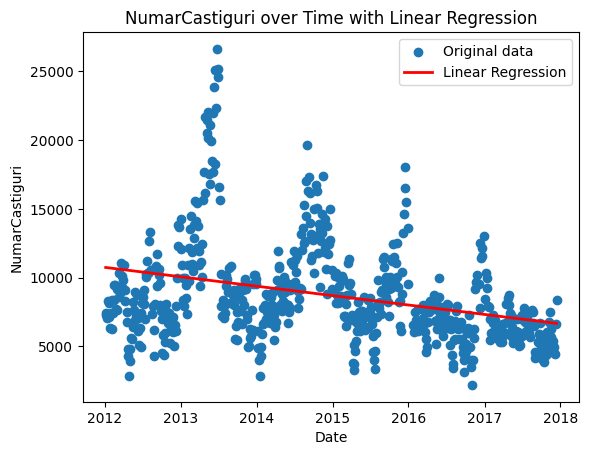

In [84]:
x = np.array(pd.to_datetime(df_cat4['DATA']).apply(lambda x: x.toordinal())).reshape(-1, 1)
y = np.array(df_cat4['NumarCastiguri_netezite'])

if len(x) != len(y):
    raise ValueError("Lengths of x and y are not the same.")

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)

plt.scatter(df_cat4['DATA'], df_cat4['NumarCastiguri_netezite'], label='Original data')

plt.plot(df_cat4['DATA'], y_pred, color='red', linewidth=2, label='Linear Regression')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Linear Regression')
plt.legend()
plt.show()


607 607 607


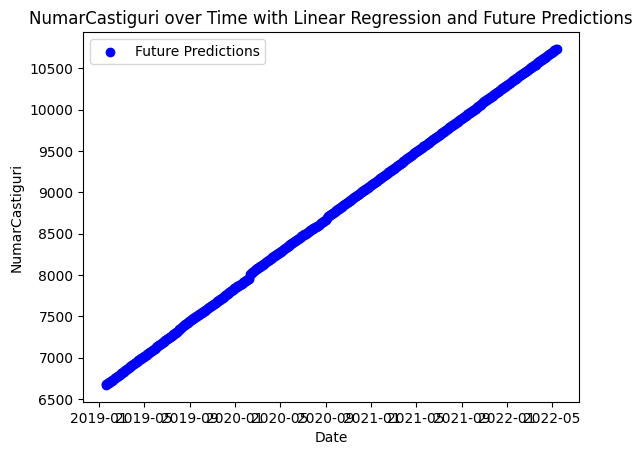

In [85]:
model = LinearRegression()

future_dates = pd.date_range(start='2019-1-18', end='2022-5-22', freq='2D')
future_dates = future_dates[:-4]

scaler = MinMaxScaler()
future_X =  scaler.fit_transform(x).reshape(-1, 1)

model.fit(future_X, y) 

future_pred = model.predict(future_X)

print(len(x),len(future_dates),len(future_pred))

plt.scatter(future_dates, future_pred, color='blue', label='Future Predictions')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Linear Regression and Future Predictions')
plt.legend()
plt.show()

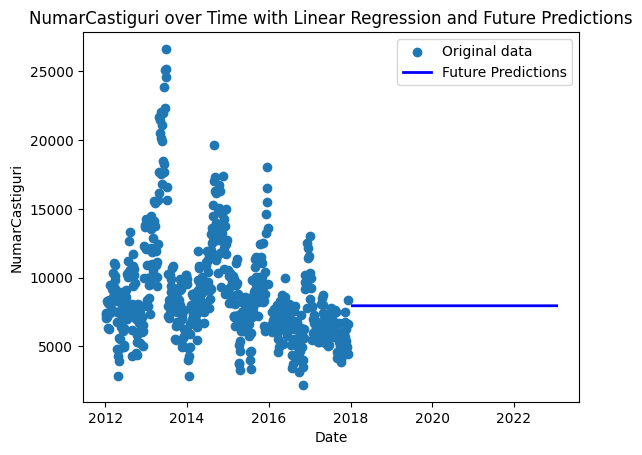

In [86]:
X = np.array(pd.to_datetime(df_cat4['DATA']).apply(lambda x: x.toordinal())).reshape(-1, 1)
y = np.array(df_cat4['NumarCastiguri_netezite'])


scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(X)

if len(X_normalized) != len(y):
    raise ValueError("Lengths of X and y are not the same.")

model =  GradientBoostingRegressor(n_estimators=150, random_state=42)

model.fit(X_normalized, y)

future_dates = pd.date_range(start='2018-1-18', end='2023-1-17', freq='D')

future_X = np.arange(len(X_normalized), len(X_normalized) + len(future_dates)).reshape(-1, 1)

future_pred = model.predict(future_X)

plt.scatter(df_cat4['DATA'], df_cat4['NumarCastiguri_netezite'], label='Original data')

plt.plot(future_dates, future_pred, color='blue', linewidth=2, label='Future Predictions')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Linear Regression and Future Predictions')
plt.legend()
plt.show()


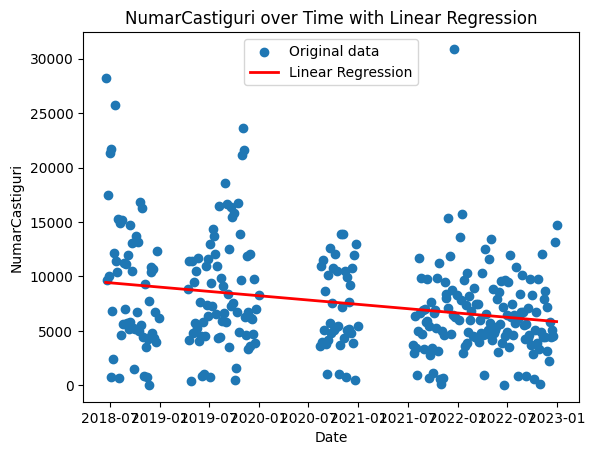

In [87]:
x = np.array(pd.to_datetime(df_test['DATA']).apply(lambda x: x.toordinal())).reshape(-1, 1)
y = np.array(df_test['NumarCastiguri'])

if len(x) != len(y):
    raise ValueError("Lengths of x and y are not the same.")

model = LinearRegression()

model.fit(x, y)


y_pred = model.predict(x)

plt.scatter(df_test['DATA'], df_test['NumarCastiguri'], label='Original data')

plt.plot(df_test['DATA'], y_pred, color='red', linewidth=2, label='Linear Regression')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Linear Regression')
plt.legend()
plt.show()


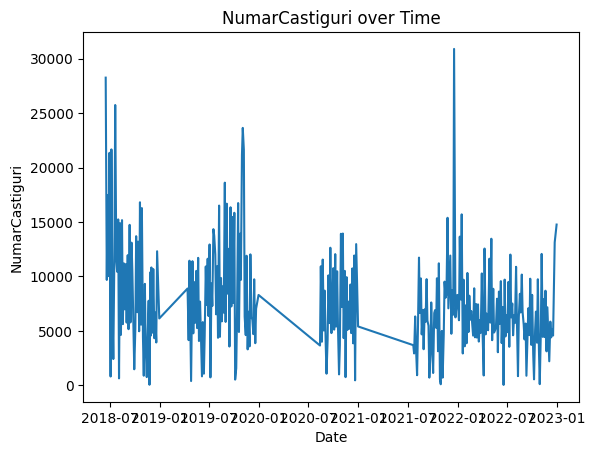

In [88]:
plt.plot(df_test['DATA'],df_test['NumarCastiguri'])
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time')
plt.show()

## Concluzie:
Regresia Liniara nu a fost chiar eficienta in a da un rezultat asupra acestui set de date, estimand o crestere a numarului de catigatori. Acest rezultat nu poate fi etichetat drept incorect caci valorile trec prin perioade de crestere si de descrestere periodic, insa analizand vizual valorile se poate constata ca tendinta numarului de castigatori este de a se micsora. Poate acesta concluzie sa fie afectata de numarul de oameni care participa la lotto?(cu siguranta).

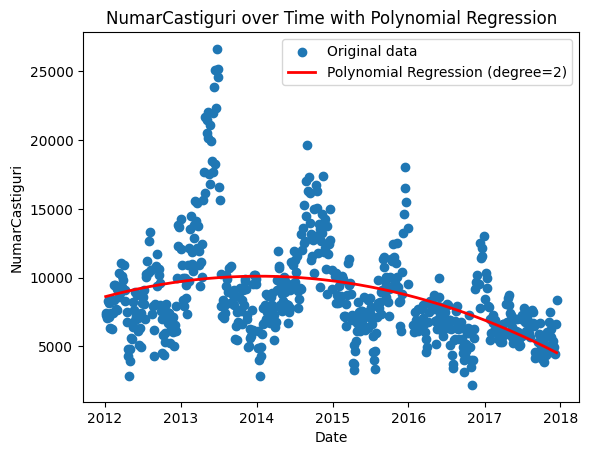

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Definirea datelor
x = np.array(pd.to_datetime(df_cat4['DATA']).apply(lambda x: x.toordinal())).reshape(-1, 1)
y = np.array(df_cat4['NumarCastiguri_netezite'])

if len(x) != len(y):
    raise ValueError("Lengths of x and y are not the same.")

# Aplicarea regresiei polinomiale
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

# Antrenarea modelului cu datele transformate
model = LinearRegression()
model.fit(x_poly, y)

# Realizarea predicțiilor pe datele de antrenament
y_pred = model.predict(x_poly)

# Vizualizarea rezultatelor
plt.scatter(df_cat4['DATA'], df_cat4['NumarCastiguri_netezite'], label='Original data')
plt.plot(df_cat4['DATA'], y_pred, color='red', linewidth=2, label='Polynomial Regression (degree=2)')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Polynomial Regression')
plt.legend()
plt.show()


607 607


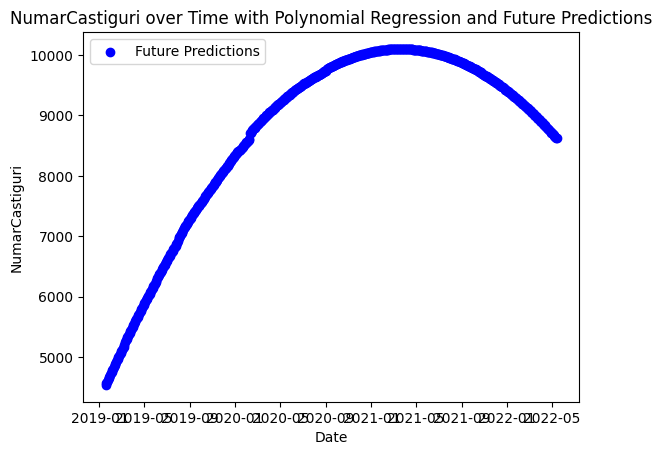

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression


y = np.array(df_cat4['NumarCastiguri_netezite'])

# Creează datele viitoare
future_dates = pd.date_range(start='2019-01-18', end='2022-05-22', freq='2D')
future_dates = future_dates[:-4]
print(len(future_dates), len(y))
# Scalați datele viitoare utilizând MinMaxScaler
scaler = MinMaxScaler()
future_X = scaler.fit_transform(x).reshape(-1, 1)

# Aplică regresia polinomială
poly_features = PolynomialFeatures(degree=2, include_bias=False)
future_X_poly = poly_features.fit_transform(future_X)

# Antrenează modelul cu datele transformate
model.fit(future_X_poly, y)

# Realizează predicții pe datele viitoare
future_pred = model.predict(future_X_poly)

# Afișează rezultatele
plt.scatter(future_dates, future_pred, color='blue', label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Polynomial Regression and Future Predictions')
plt.legend()
plt.show()



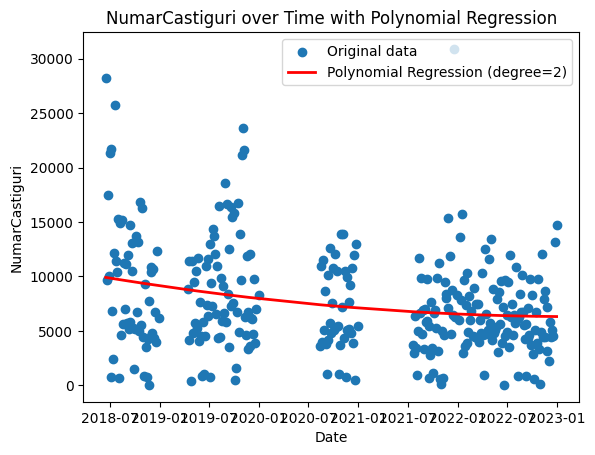

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Definirea datelor
x = np.array(pd.to_datetime(df_test['DATA']).apply(lambda x: x.toordinal())).reshape(-1, 1)
y = np.array(df_test['NumarCastiguri'])

if len(x) != len(y):
    raise ValueError("Lengths of x and y are not the same.")

# Aplicarea regresiei polinomiale
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

# Antrenarea modelului cu datele transformate
model = LinearRegression()
model.fit(x_poly, y)

# Realizarea predicțiilor pe datele de antrenament
y_pred = model.predict(x_poly)

# Vizualizarea rezultatelor
plt.scatter(df_test['DATA'], df_test['NumarCastiguri'], label='Original data')
plt.plot(df_test['DATA'], y_pred, color='red', linewidth=2, label='Polynomial Regression (degree=2)')

plt.xlabel('Date')
plt.ylabel('NumarCastiguri')
plt.title('NumarCastiguri over Time with Polynomial Regression')
plt.legend()
plt.show()
